In [5]:
import cvxpy as cp
import networkx as nx
import numpy as np

In [6]:
import heapq
import networkx as nx

def longest_path_first_topological_sort(graph):
    # Calculate the longest path lengths to each node
    longest_path_length = {node: 0 for node in graph.nodes()}
    for node in reversed(list(nx.topological_sort(graph))):  # Use topological sort to order nodes
        for successor in graph.successors(node):
            longest_path_length[node] = max(longest_path_length[node], 1 + longest_path_length[successor])

    # Initialize a priority queue based on longest path lengths
    priority_queue = []
    in_degree = {node: 0 for node in graph.nodes()}
    for u, v in graph.edges():
        in_degree[v] += 1

    # Populate the priority queue with nodes having zero in-degree
    for node in graph.nodes():
        if in_degree[node] == 0:
            heapq.heappush(priority_queue, (-longest_path_length[node], node))  # Push with negative to simulate max heap

    topological_order = []
    while priority_queue:
        _, node = heapq.heappop(priority_queue)
        topological_order.append(node)
        for successor in graph.successors(node):
            in_degree[successor] -= 1
            if in_degree[successor] == 0:
                heapq.heappush(priority_queue, (-longest_path_length[successor], successor))  # Maintain priority

    return topological_order


### Optimizing Longest Path Latency (longest path first topo sort)

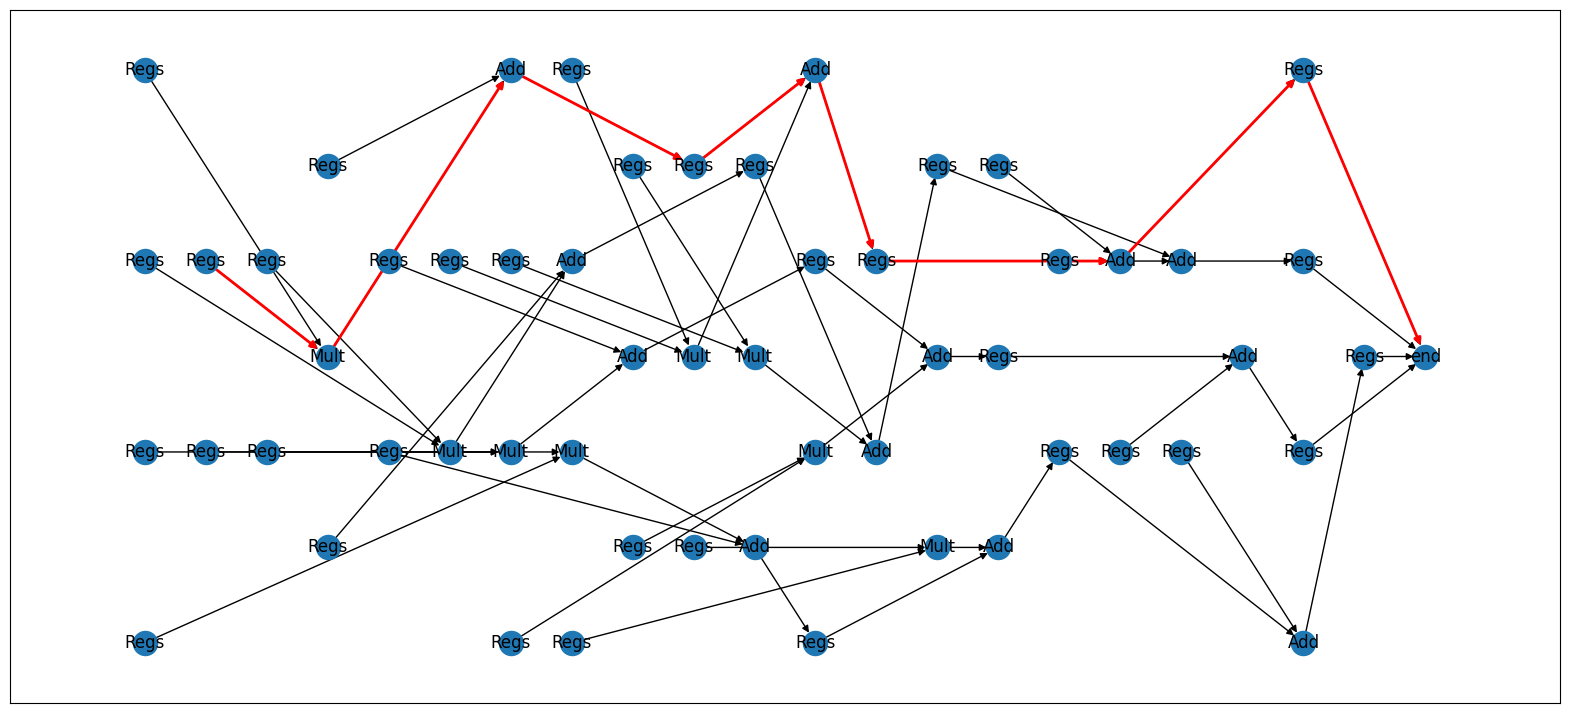

In [11]:
graph = nx.read_gml("matmult2.gml") # REPLACE WITH PATH OF OUR CDFG
graph_nodes = graph.nodes(data=True)
hw_element_counts = {'Eq': 1, 'Regs': 4, 'Buf': 2, 'MainMem': 1, 'Add': 1, 'Mult': 1, 'stall': float('inf')}
graph_nodes = graph.nodes(data=True)

############ CREATING VARIABLES AND DATA DEPENDENCY CONSTRAINTS ############

constraints = []
vars = []

# graph nodes
id = 0
for node in graph_nodes:
    curr_var = cp.Variable(2, name = node[0]) # first one is start time and last one is end time
    # curr_var.name = node[0]
    vars.append(curr_var)
    node[1]['scheduling_id'] = id
    id += 1
    constraints.append(curr_var[0] >= 0)
    if 'cost' in node[1].keys():
        constraints.append(curr_var[0] + node[1]['cost'] == curr_var[1])

for u, v in graph.edges():
    # if 'idx'
    source_id = int(graph_nodes[u]['scheduling_id'])
    dest_id = int(graph_nodes[v]['scheduling_id'])
    constraints.append(vars[source_id][1] - vars[dest_id][0] <= 0.0)


############ CREATING RESOURCE CONSTRAINTS  ############

topological_order = longest_path_first_topological_sort(graph)
resource_constraints = []
for i in range(len(topological_order)):
    # curr_reg_count = {'Regs': 0, 'Add': 0, 'Mult': 0, 'Buf': 0, 'Eq': 0, 'stall': 0}
    curr_func_count = 0
    start_node = topological_order[i]
    if graph.nodes[start_node]['function'] not in hw_element_counts.keys():
        continue
    # curr_reg_count[graph.nodes[start_node]['function']] += 1
    curr_func_count += 1
    for j in range(i + 1, len(topological_order)):
        curr_node = topological_order[j]
        if graph.nodes[curr_node]['function'] not in hw_element_counts.keys():
                continue
        # curr_reg_count[graph.nodes[curr_node]['function']] += 1
        if graph.nodes[curr_node]['function'] == graph.nodes[start_node]['function']:
            curr_func_count += 1
            if curr_func_count > 2*hw_element_counts[graph.nodes[curr_node]['function']]:
                break
            if curr_func_count > hw_element_counts[graph.nodes[curr_node]['function']]:
                # add a constraint
                resource_constraints.append(vars[graph.nodes[start_node]['scheduling_id']][0] - vars[graph.nodes[curr_node]['scheduling_id']][0] <= -graph.nodes[start_node]['cost'])
                # break
    # print(curr_reg_count)
constraints += resource_constraints

############ RUNNING OPTIMIZATION  ############


obj = cp.Minimize(vars[graph_nodes['end']['scheduling_id']][0])
prob = cp.Problem(obj, constraints)
prob.solve()

############ PLOTTING OPTIMAL SCHEDULE  ############

import matplotlib.pyplot as plt
for node in graph_nodes:
    start_time, end_time = vars[node[1]['scheduling_id']].value
    node[1]['start_time'] = np.round(start_time)
    node[1]['end_time'] = np.round(end_time)
plt.figure(figsize=(20,9))
labels = {node: data['function'] for node, data in graph.nodes(data=True)}
longest_path = nx.dag_longest_path(graph)
pos = nx.multipartite_layout(graph, subset_key="start_time")
nx.draw_networkx(graph, with_labels=True, labels=labels, pos=pos, font_size=12)

if 'longest_path' in locals():  # Check if longest_path was successfully found
    longest_path_edges = list(zip(longest_path[:-1], longest_path[1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=longest_path_edges, edge_color='red', width=2)

# for node in longest_path:
#     print("Node:", node, "Start time:", graph.nodes[node]['start_time'], "End Time:", graph.nodes[node]['end_time'])

ax = plt.gca()

### Optimizing Longest Path Latency (multiple topo sorts)

In [3]:
def limited_topological_sorts(graph, max_sorts=10):
    in_degree = {node: 0 for node in graph.nodes()}
    for u, v in graph.edges():
        in_degree[v] += 1

    partial_order = []
    sorts_found = 0
    
    def visit():
        nonlocal sorts_found
        if sorts_found >= max_sorts:
            return

        all_visited = True
        for node in graph.nodes():
            if in_degree[node] == 0 and node not in partial_order:
                all_visited = False
                partial_order.append(node)
                for successor in graph.successors(node):
                    in_degree[successor] -= 1

                yield from visit()

                partial_order.pop()
                for successor in graph.successors(node):
                    in_degree[successor] += 1
        
        if all_visited:
            sorts_found += 1
            yield list(partial_order)

    return list(visit())

In [12]:
all_sorted = limited_topological_sorts(graph, max_sorts = 3)

final_vars = []
final_optim_val = float('inf')

all_optim_vals = []
print("Trying", len(all_sorted), "topological sorts")
for top_order in all_sorted:
    curr_constraints = []

    ### Introducing Variables
    vars = []
    id = 0
    for node in graph_nodes:
        curr_var = cp.Variable(2) # first one is start time and last one is end time
        vars.append(curr_var)
        # start time + latency = end time for each operating node
        node[1]['scheduling_id'] = id
        id += 1
        curr_constraints.append(curr_var[0] >= 0)
        curr_constraints.append(curr_var[1] >= 0)
        if 'cost' in node[1].keys():
            curr_constraints.append(curr_var[0] + node[1]['cost'] == curr_var[1])
    
    ### Data Dependencies
    for u, v in graph.edges():
        source_id = int(graph_nodes[u]['scheduling_id'])
        dest_id = int(graph_nodes[v]['scheduling_id'])
        curr_constraints.append(vars[source_id][1] - vars[dest_id][0] <= 0)
        
    ### Resource Dependencies
    for i in range(len(top_order)):
        curr_reg_count = {'Regs': 0, 'Add': 0, 'Mult': 0, 'Buf': 0, 'Eq': 0, 'stall': 0}
        start_node = top_order[i]
        if graph.nodes[start_node]['function'] not in curr_reg_count:
            continue
        curr_reg_count[graph.nodes[start_node]['function']] += 1
        for j in range(i + 1, len(top_order)):
            curr_node = top_order[j]
            if graph.nodes[curr_node]['function'] not in curr_reg_count:
                continue
            curr_reg_count[graph.nodes[curr_node]['function']] += 1
            if graph.nodes[curr_node]['function'] == graph.nodes[start_node]['function']:
                if curr_reg_count[graph.nodes[curr_node]['function']] > 2 * hw_element_counts[graph.nodes[curr_node]['function']]:
                    break
                if curr_reg_count[graph.nodes[curr_node]['function']] > hw_element_counts[graph.nodes[curr_node]['function']]:
                    # add a constraint
                    curr_constraints.append(vars[graph.nodes[start_node]['scheduling_id']][0] - vars[graph.nodes[curr_node]['scheduling_id']][0] <= -graph.nodes[start_node]['cost'])
    
    # constraints += curr_constraints
    obj = cp.Minimize(vars[graph_nodes['end']['scheduling_id']][0])
    prob = cp.Problem(obj, curr_constraints)
    prob.solve()
    all_optim_vals.append(prob.value)
    if prob.value < final_optim_val:
        final_optim_val = prob.value
        final_vars = vars
print("End Node Optimal Time: ", final_optim_val)
print("All Optimal Values: ", all_optim_vals)

Trying 3 topological sorts
End Node Optimal Time:  38.38000001480581
All Optimal Values:  [38.380000016048875, 38.38000001480581, 38.38000001480581]


### Greedy Bubble-up Scheduling

In [13]:
def assign_upstream_path_lengths(graph):
    """
    Assigns the longest path to each node in the graph.
    Currently ignores actual latencies of nodes.
    TODO: change this to dijkstra
    """
    for node in graph:
        graph.nodes[node]["dist"] =  0
    for i, generations in enumerate(nx.topological_generations(graph)):
        for node in generations:
            graph.nodes[node]["dist"] = max(i, graph.nodes[node]["dist"])
    
    return graph
    
def greedy_schedule_with_stall(computation_graph, hw_element_counts):
    """
    Schedules the computation graph on the hardware netlist
    by determining the order of operations and the states in which
    they are executed. Includes the adding of stalls to account for
    data dependencies and in use elements.
    """

    hw_element_counts["stall"] = np.inf
    # print(f"hw_element_counts: {hw_element_counts}")

    # do topo sort from beginning and add dist attribute to each node
    # for longest path to get to it from a gen[0] node.

    # reset layers:
    for node in computation_graph.nodes:
        computation_graph.nodes[node]["layer"] = -np.inf
    assign_upstream_path_lengths(computation_graph)

    stall_counter = 0 # used to ensure unique stall names
    pushed = []
    # going through the computation graph from the end to the beginning and bubbling up operations
    generations = list(nx.topological_generations(nx.reverse(computation_graph)))
    layer = 0
    while layer < len(generations) or len(pushed) != 0:
        # print(f"layer: {layer}; pushed: {pushed}")
        if layer >= len(generations):
            generation = []
        else:
            generation = generations[layer]
        generation += pushed
        pushed = []

        # if any horizontal dependencies, push them to the next layer
        for node in generation:
            out_nodes = list(map(lambda x: x[1], computation_graph.out_edges(node)))
            intersect = set(out_nodes).intersection(set(generation))
            if intersect:
                pushed.append(node)
            else:
                computation_graph.nodes[node]["allocation"] = ""
                computation_graph.nodes[node]["layer"] = -layer
        # print(f"generation before removing horizontal: {generation}")
        generation = [
            item for item in generation if item not in pushed
        ]
        # print(f"generation after removing horizontal: {generation}")

        nodes_in_gen = list(filter(lambda x: x[0] in generation, computation_graph.nodes.data()))
        # print(f"layers in gen: {list(map(lambda x: x[1]['layer'], nodes_in_gen))}")
        funcs_in_gen, counts_in_gen = np.unique(
            list(map(lambda x: x[1]["function"], nodes_in_gen)), return_counts=True
        )

        for func, count in zip(funcs_in_gen, counts_in_gen): # for each function in the generation
            # print(f"func: {func}; count: {count}")
            if func == "start" or func == "end":
                continue
            if count > hw_element_counts[func]:
                # print(f"more ops than hw elements for {func}")
                func_nodes = list(filter(lambda x: x[1]["function"] == func, nodes_in_gen))
                # print(f"func_nodes: {func_nodes}")
                func_nodes = sorted(func_nodes, key=lambda x: x[1]["dist"], reverse=True)
                # print(f"sorted func_nodes: {func_nodes}")

                start_idx = hw_element_counts[func]
                # TODO: pic this range based on upstream length. Calculated by Dijkstra
                for idx in range(start_idx, count):
                    # print(f"idx: {idx}; node: {func_nodes[idx][0]}; removing node from gen")
                    # generation.remove(func_nodes[idx][0])
                    # an out edge in comp_dfg is an in_edge in the reversed_graph
                    out_edges = list(computation_graph.out_edges(func_nodes[idx][0]))

                    stall_name = f"stall_{layer}_{idx}_{func}_{stall_counter}"
                    stall_counter += 1
                    # print(f"adding stall: {stall_name} for {func}")
                    computation_graph.add_node(
                        stall_name,
                        function="stall",
                        cost=func_nodes[idx][1]["cost"],
                        layer= -layer,
                    )
                    # print(f"adding stall: {stall_name}: {computation_graph.nodes[stall_name]}")
                    new_edges = []
                    for edge in out_edges:
                        new_edges.append((stall_name, edge[1], {"weight": computation_graph.edges[edge]["weight"]}))
                        new_edges.append((edge[0], stall_name, {"weight": computation_graph.edges[edge]["weight"]})) # edge[0] is same as func_nodes[idx][0]
                    computation_graph.add_edges_from(
                        new_edges
                    )
                    computation_graph.remove_edges_from(out_edges)

                    computation_graph.nodes[func_nodes[idx][0]]["layer"] = -(layer + 1) # bubble up
                    # print(f"node after bubbling: {func_nodes[idx][0]}: {computation_graph.nodes[func_nodes[idx][0]]}")
                    pushed.append(func_nodes[idx][0])

        # print(f"plotting processed graph")
        hopeful_nodes = list(filter(
            lambda x: x[1]["layer"] >= -layer, computation_graph.nodes.data()
        ))
        # print(f"layers: {[x[1]['layer'] for x in hopeful_nodes]}")
        processed_nodes = list(map(lambda x: x[0], hopeful_nodes))
        # print(f"processed_nodes: {processed_nodes}")
        processed_graph = nx.subgraph(computation_graph, processed_nodes)

        curr_gen_nodes = list(filter(lambda x: x[1]["layer"] == -layer, computation_graph.nodes.data()))
        funcs_in_gen, counts_in_gen = np.unique(
            list(map(lambda x: x[1]["function"], curr_gen_nodes)), return_counts=True
        )

        for i, func in enumerate(funcs_in_gen):
            if func in ["start", "end"]:
                continue
            assert counts_in_gen[i] <= hw_element_counts[func]

        # print(f"funcs_in_gen: {funcs_in_gen}; counts_in_gen: {counts_in_gen}")
        # print(f"hw_element_counts: {hw_element_counts}")

        layer += 1
    cycles = nx.dag_longest_path_length(computation_graph)
    plt.figure(figsize=(15,9))
    labels = {node: data['function'] for node, data in graph.nodes(data=True)}
    # nx.draw_networkx(computation_graph, with_labels = True, labels=labels, pos=nx.multipartite_layout(graph, subset_key="layer"), font_size = 8, label='function')
    # # print(list(computation_graph.nodes(data=True)))
    # # nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), edge_color='black')
    # pos = nx.multipartite_layout(computation_graph, subset_key="layer")
    # longest_path = nx.dag_longest_path(computation_graph)
    # if 'longest_path' in locals():  # Check if longest_path was successfully found
    #     longest_path_edges = list(zip(longest_path[:-1], longest_path[1:]))
    #     nx.draw_networkx_edges(computation_graph, pos, edgelist=longest_path_edges, edge_color='red', width=2)

    print("Vamshi Scheduling Cycles: ",  cycles)

def greedy_schedule_without_stall(computation_graph, hw_element_counts):
    # hw_element_counts["stall"] = np.inf  # Stall is set to infinite, but we won't use it.
    
    # Reset layers:
    for node in computation_graph.nodes:
        computation_graph.nodes[node]["layer"] = -np.inf
    assign_upstream_path_lengths(computation_graph)

    pushed = []
    generations = list(nx.topological_generations(nx.reverse(computation_graph)))
    layer = 0

    while layer < len(generations) or len(pushed) != 0:
        if layer >= len(generations):
            generation = []
        else:
            generation = generations[layer]
        generation += pushed
        pushed = []

        for node in generation:
            out_nodes = list(map(lambda x: x[1], computation_graph.out_edges(node)))
            intersect = set(out_nodes).intersection(set(generation))
            if intersect:
                pushed.append(node)
            else:
                computation_graph.nodes[node]["allocation"] = ""
                computation_graph.nodes[node]["layer"] = -layer

        generation = [item for item in generation if item not in pushed]

        nodes_in_gen = list(filter(lambda x: x[0] in generation, computation_graph.nodes.data()))

        funcs_in_gen, counts_in_gen = np.unique(
            list(map(lambda x: x[1]["function"], nodes_in_gen)), return_counts=True
        )

        for func, count in zip(funcs_in_gen, counts_in_gen):
            if func in ["start", "end"]:
                continue
            if count > hw_element_counts[func]:
                func_nodes = sorted(
                    filter(lambda x: x[1]["function"] == func, nodes_in_gen),
                    key=lambda x: x[1]["dist"], reverse=True
                )
                
                for idx in range(hw_element_counts[func], len(func_nodes)):
                    computation_graph.nodes[func_nodes[idx][0]]["layer"] = -(layer + 1)
                    pushed.append(func_nodes[idx][0])

        layer += 1

    # Redraw the graph without stall nodes
    cycles = nx.dag_longest_path_length(computation_graph)
    plt.figure(figsize=(15,9))
    labels = {node: data['function'] for node, data in computation_graph.nodes(data=True)}
    nx.draw_networkx(computation_graph, with_labels=True, labels=labels, pos=nx.multipartite_layout(computation_graph, subset_key="layer"), font_size=8, label='function')

    print("Vamshi Scheduling Cycles: ", cycles)


In [ ]:
graph = nx.read_gml("matmult2.gml")
greedy_schedule_with_stall(graph, hw_element_counts)
greedy_schedule_without_stall(graph, hw_element_counts)